In [44]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


In [32]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UAS CC/data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes


In [33]:
df['Dangerous'].value_counts()

,count
Dangerous,
Yes,849
No,20


In [34]:
#memisahkan data label
X = df.drop (columns='Dangerous', axis=1)
Y = df['Dangerous']

In [35]:
#PREPROCESSING
df['combined_symptoms'] = df[['symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5']].astype(str).agg(' '.join, axis=1)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['processed_symptoms'] = df['combined_symptoms'].apply(preprocess)
df['Dangerous'] = df['Dangerous'].replace('yes', 'Yes') # Standardize 'yes' to 'Yes'
df[['AnimalName', 'combined_symptoms', 'processed_symptoms', 'Dangerous']].head()

,AnimalName,combined_symptoms,processed_symptoms,Dangerous
0,Dog,Fever Diarrhea Vomiting Weight loss Dehydration,fever diarrhea vomiting weight loss dehydration,Yes
1,Dog,Fever Diarrhea Coughing Tiredness Pains,fever diarrhea coughing tiredness pains,Yes
2,Dog,Fever Diarrhea Coughing Vomiting Anorexia,fever diarrhea coughing vomiting anorexia,Yes
3,Dog,Fever Difficulty breathing Coughing Lethargy S...,fever difficulty breathing coughing lethargy s...,Yes
4,Dog,Fever Diarrhea Coughing Lethargy Blue Eye,fever diarrhea coughing lethargy blue eye,Yes


In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_symptoms'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Dangerous'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(871, 863) (696, 863) (175, 863)


In [37]:
#Training model SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

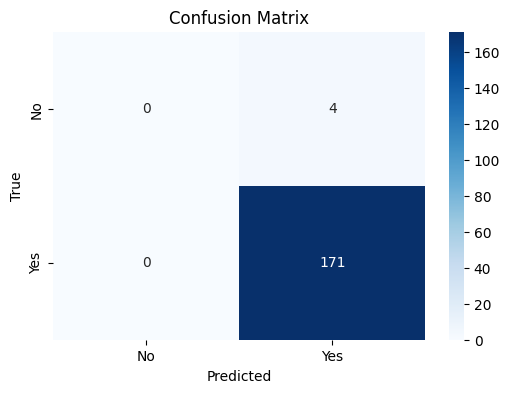

Classification Report
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         4
         Yes       0.98      1.00      0.99       171

    accuracy                           0.98       175
   macro avg       0.49      0.50      0.49       175
weighted avg       0.95      0.98      0.97       175

Accuracy: 97.71 %


In [41]:
y_pred = svm.predict(X_test)

unique_labels = sorted(set(y_test))
labels_str = label_encoder.inverse_transform(unique_labels)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_str,
            yticklabels=labels_str)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report")
print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.inverse_transform(unique_labels),
    zero_division=0
))

# Akurasi
accuracy = svm.score(X_test, y_test)
print("Accuracy:", round(accuracy * 100, 2), "%")

In [42]:
def klasifikasi_interaktif():
    print("=== ❗❗Lihat Bahaya Penyakit Hewanmu❗❗ ===")
    print("Ketik 'exit' kapan saja untuk keluar.\n")

    while True:
        animal = input("Jenis Hewan (eng): ")
        if animal.lower() == 'exit':
            print("Program dihentikan.")
            break

        symptoms = input("Gejala yang dialami (eng): ")
        if symptoms.lower() == 'exit':
            print("Program dihentikan.")
            break

        processed_input = preprocess(symptoms)
        input_vector = vectorizer.transform([processed_input])

        filtered_df = df[df['AnimalName'].str.lower() == animal.lower()]

        if filtered_df.empty:
            print(f"❌ Data untuk hewan '{animal}' tidak ditemukan.\n")
            print("="*40 + "\n")
            continue

        filtered_vectors = vectorizer.transform(filtered_df['processed_symptoms'])
        similarities = cosine_similarity(input_vector, filtered_vectors).flatten()

        best_idx = similarities.argmax()
        best_similarity = similarities[best_idx]

        if best_similarity < 0.2:
            print("❗ Pastikan input gejala dengan benar.")
            print("Prediksi tidak dapat ditentukan dengan pasti.\n")
            print("="*40 + "\n")
            continue

        best_row = filtered_df.iloc[best_idx]

        print("\n=== Hasil Prediksi ===")
        print(f"Hewan: {animal}")
        print(f"Gejala Input: {symptoms}")
        print(f"Gejala Paling Mirip: {best_row['combined_symptoms']}")
        print(f"Similarity Score: {round(best_similarity, 3)}")
        print(f"Klasifikasi Berbahaya: {best_row['Dangerous']}")
        print("="*40 + "\n")

klasifikasi_interaktif()

=== ❗❗Lihat Bahaya Penyakit Hewanmu❗❗ ===
Ketik 'exit' kapan saja untuk keluar.

Jenis Hewan (eng): exit
Program dihentikan.


In [59]:
#simpan model
import pickle

filename = 'animcond_model.sav'
pickle.dump(svm, open(filename, 'wb'))

In [60]:
model_path = '/content/drive/MyDrive/Colab Notebooks/UAS CC/animcond_model.sav'
with open(model_path, 'wb') as file:
    pickle.dump(svm, file)

In [ ]:
import pickle
with open('animcond_model.sav', 'rb') as f:
    model = pickle.load(f)